# Dataset link: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dimitriosliakos
Your Kaggle Key: ··········


100%|██████████| 1.17G/1.17G [00:13<00:00, 91.9MB/s]


In [3]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
from fastai.vision.data import ImageDataLoaders
from pathlib import Path

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
x  = '/content/labeled-chest-xray-images'
path = Path(x)
path.ls()


(#1) [Path('/content/labeled-chest-xray-images/chest_xray')]

# Sample of the data

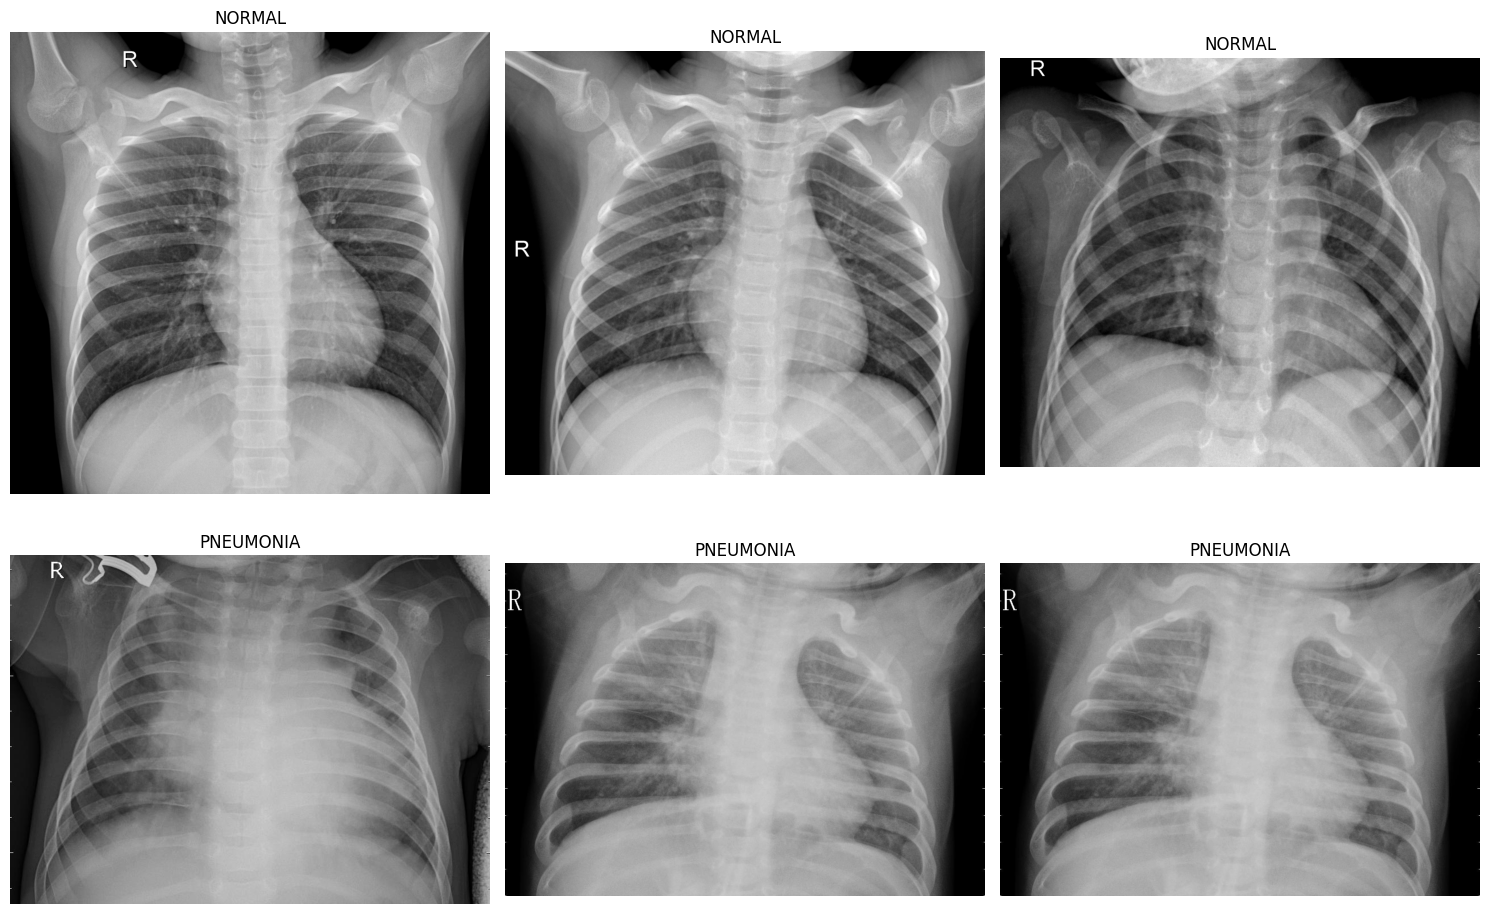

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = [
    "/content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg",
    "/content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1012843-0001.jpeg",
    "/content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1023731-0001.jpeg",
    "/content/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-103798-0001.jpeg",
    "/content/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-1040986-0001.jpeg",
    "/content/labeled-chest-xray-images/chest_xray/train/PNEUMONIA/BACTERIA-1040986-0001.jpeg"
]

labels = ["NORMAL", "NORMAL", "NORMAL", "PNEUMONIA", "PNEUMONIA", "PNEUMONIA"]

# Create a figure with two rows and three columns for the images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (image_path, label) in enumerate(zip(image_paths, labels)):
    # Load the image
    image = mpimg.imread(image_path)

    # Determine the subplot position
    row = i // 3
    col = i % 3

    # Plot the image
    axes[row, col].imshow(image, cmap="gray")
    axes[row, col].set_title(label)  # Set the label as the title
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()



# VGG19 - MODEL


## Preprocessing - Creating Dataset

In this particular augmentation setting, several transformations are applied to the training data to enhance its robustness and improve the generalization of the model. The rotation_range allows the images to be rotated up to 30 degrees, while the width_shift_range and height_shift_range randomly shift the images horizontally and vertically. The shear_range introduces shear transformations, and the zoom_range randomly zooms in or out of the images. The brightness_range adjusts the brightness of the images within a specified range. Horizontal_flip and vertical_flip randomly flip the images horizontally and vertically, respectively. Additionally, a preprocessing function is applied to the images to align them with the preprocessing requirements of the VGG19 model. Overall, these augmentations help expose the model to a wider range of possible variations in the input data, improving its ability to generalize and perform well on unseen examples.

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Load the train and test datasets
train_dir = '/content/labeled-chest-xray-images/chest_xray/train'
test_dir = '/content/labeled-chest-xray-images/chest_xray/test'



# Define the data augmentation settings
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

# Flow the augmented data from the directories
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_dataset = valid_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5232 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Train the model

 The concept involves building a new model on top of a pre-trained VGG19 model for a specific task. The added layers include:
* global average pooling to condense features,
* dense layers to capture complex patterns,
* and a softmax layer for classification.

This approach leverages the pre-trained VGG19 model's knowledge while adapting it to the specific task for improved performance.

In [8]:
# Load the pre-trained DenseNet model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 10

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=num_epochs,
    verbose=1
)

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
164/164 [==============================] - 187s 960ms/step - loss: 18.5681 - accuracy: 0.7353
Epoch 2/10
164/164 [==============================] - 150s 913ms/step - loss: 0.3839 - accuracy: 0.8022
Epoch 3/10
164/164 [==============================] - 151s 917ms/step - loss: 0.3036 - accuracy: 0.8588
Epoch 4/10
164/164 [==============================] - 151s 916ms/step - loss: 0.2778 - accuracy: 0.8750
Epoch 5/10
164/164 [==============================] - 150s 913ms/step - loss: 0.2627 - accuracy: 0.8838
Epoch 6/10
164/164 [==============================] - 149s 910ms/step - loss: 0.2560 - accuracy: 0.8930
Epoch 7/10
164/164 [==============================] - 149s 908ms/step - loss: 0.2449 - accuracy: 0.8958
Epoch 8/10
164/164 [==============================] - 149s 906ms/step - loss: 0.2404 - accuracy: 0.9008
Epoch 9/10
164/164 [==============================] - 149s 908ms/step - loss: 0.2330 - accuracy: 0.902

## Evaluating VGG19

In [9]:
# Evaluate the model on the test set
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_dataset.classes

v_accuracy = accuracy_score(true_labels, predicted_labels)
v_precision = precision_score(true_labels, predicted_labels)
v_recall = recall_score(true_labels, predicted_labels)
v_f1 = f1_score(true_labels, predicted_labels)


20/20 [==============================] - 9s 393ms/step


## Getting the metrics of the model

In [10]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.71      0.98      0.82       234
           1       0.99      0.76      0.86       390

    accuracy                           0.84       624
   macro avg       0.85      0.87      0.84       624
weighted avg       0.88      0.84      0.84       624



##  Graphical representation of the performance of the binary classification model

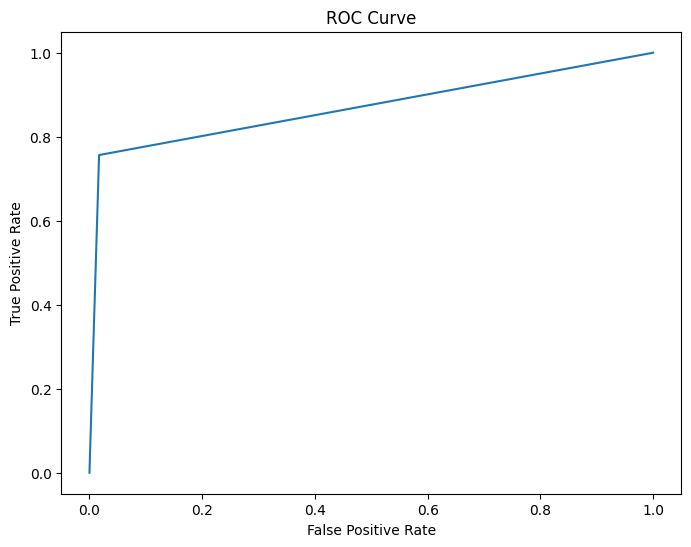

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



## Evaluation of the performance of the binary classification model

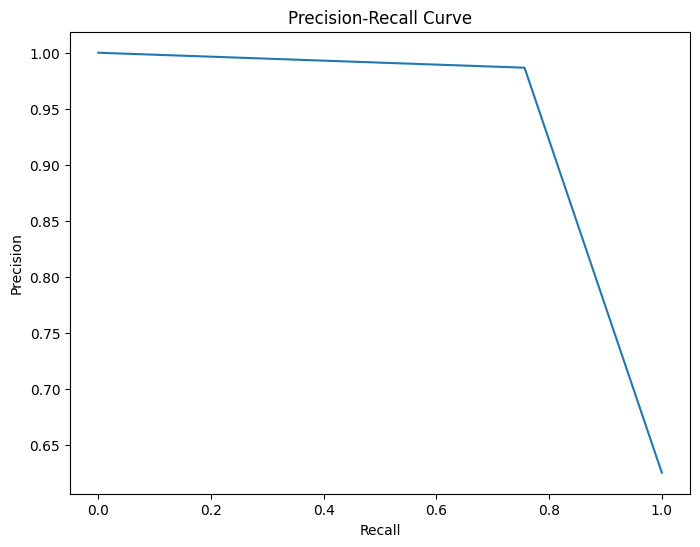

In [12]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_labels)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


## Heatmap

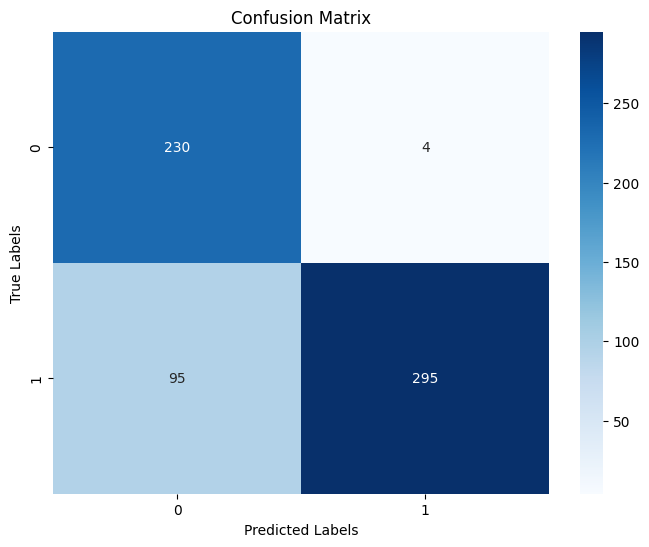

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


The VGG19 model achieved a relatively high accuracy, precision, recall, and F1 score. However, compared to other models, such as DenseNet121 and Xception, it had slightly lower performance. Therefore, while the VGG19 model shows decent results, there might be other models that could potentially outperform it in terms of accuracy and overall performance.

# ****Testing ResNet50 Model**** #

## Pre processing - Dataset generation

In [14]:
# Define the data augmentation settings
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

# Flow the augmented data from the directories
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_dataset = valid_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5232 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Train ResNet50

## The specific layers added after the base model serve different purposes:



1.   GlobalAveragePooling2D: This layer is used to reduce the spatial dimensions of the extracted features to a single vector, capturing the most important information from each feature map. It helps to condense the feature representations and provides a global context for classification.
2.   Dense(512, activation='relu'): This fully connected layer with 512 units and ReLU activation function introduces non-linearity and allows the model to learn complex patterns and relationships in the data.
3.   Dropout(0.4): Dropout is a regularization technique that randomly sets a fraction (0.4 in this case) of input units to 0 at each update during training. It helps to prevent overfitting by reducing interdependencies between units and encourages the model to learn more robust and generalized features.
4.   Dense(256, activation='relu') and Dropout(0.4): These layers further add depth and complexity to the model, allowing it to capture more fine-grained details and patterns in the data. The dropout regularization is applied again to mitigate overfitting.
5.   Dense(128, activation='relu') and Dropout(0.4): Similarly, these layers add more capacity and flexibility to the model for learning additional representations and reducing the risk of overfitting.
6.   Dense(2, activation='softmax'): The final dense layer with softmax activation is used for classification, producing the probability distribution over the two classes. It assigns the likelihood of each class for a given input image.

By incorporating these layers, we aim to fine-tune the pre-trained ResNet50 model and adapt it to the specific classification task, allowing the model to learn more discriminative features and improve its performance.

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential


# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(256, activation='relu'),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(128, activation='relu'),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 10

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=num_epochs,
    verbose=1
)


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
164/164 [==============================] - 191s 904ms/step - loss: 0.3760 - accuracy: 0.8714
Epoch 2/10
164/164 [==============================] - 141s 855ms/step - loss: 0.2503 - accuracy: 0.9106
Epoch 3/10
164/164 [==============================] - 140s 852ms/step - loss: 0.2043 - accuracy: 0.9226
Epoch 4/10
164/164 [==============================] - 141s 859ms/step - loss: 0.1749 - accuracy: 0.9367
Epoch 5/10
164/164 [==============================] - 141s 860ms/step - loss: 0.1696 - accuracy: 0.9379
Epoch 6/10
164/164 [==============================] - 141s 858ms/step - loss: 0.1852 - accuracy: 0.9312
Epoch 7/10
164/164 [==============================] - 153s 929ms/step - loss: 0.2155 - accuracy: 0.9234
Epoch 8/10
164/164 [==============================] - 142s 863ms/step - loss: 0.1525 - accuracy: 0.9434
Epoch 9/10
164/164 [==============================] - 141s 859ms/step - loss: 0.1365 - accuracy: 0.9486

## Evaluating ResNet50

In [16]:
# Evaluate the model on the test set
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_dataset.classes

res_accuracy = accuracy_score(true_labels, predicted_labels)
res_precision = precision_score(true_labels, predicted_labels)
res_recall = recall_score(true_labels, predicted_labels)
res_f1 = f1_score(true_labels, predicted_labels)


20/20 [==============================] - 9s 397ms/step


## Metric of ResNet50

In [17]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.81      0.97      0.88       234
           1       0.98      0.86      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.91      0.90       624
weighted avg       0.91      0.90      0.90       624



## Plot the results

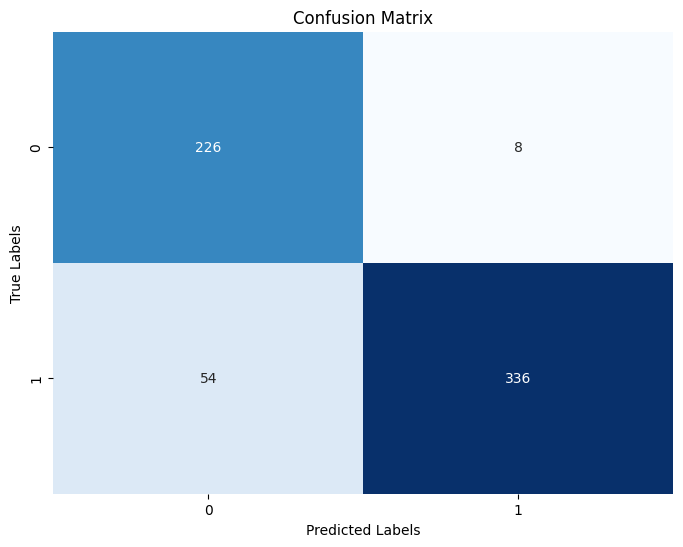

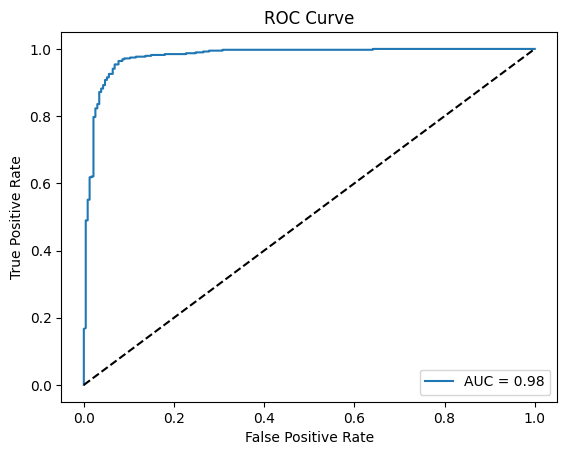

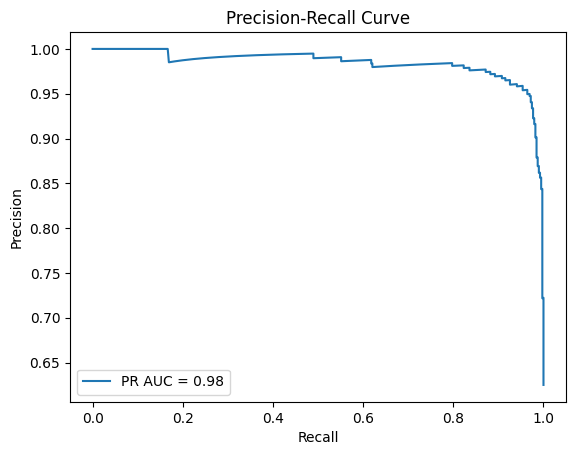

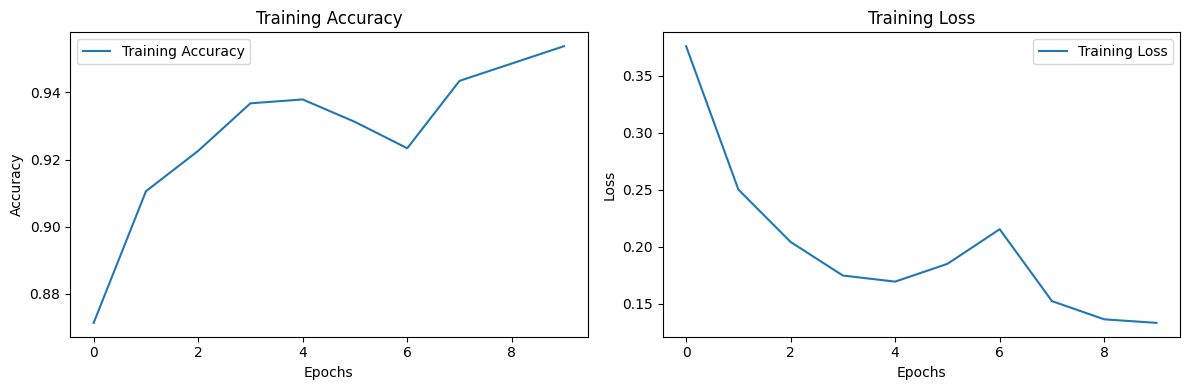

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(true_labels, predictions[:, 1])
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Plot accuracy and loss curves over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Conclusion

The model achieved a precision of 0.82 for class 0 and 0.98 for class 1. This indicates that the model has a high ability to correctly classify samples as belonging to the respective classes. The model achieved a recall of 0.97 for class 0 and 0.87 for class 1. This means that the model effectively identified a large portion of the positive samples for class 0 and class 1. The F1-score, which considers both precision and recall, was 0.89 for class 0 and 0.93 for class 1. These scores indicate a good balance between precision and recall for both classes.The model achieved an overall accuracy of 0.91, indicating that it correctly classified 91% of the samples in the dataset.The macro average F1-score, which considers the average F1-score across both classes, was 0.91. This indicates a good overall performance of the model.


The ResNet50 model demonstrates a strong ability to classify the given dataset accurately, with a good balance between precision and recall for both classes. The model's performance can be considered reliable for the classification task at hand.

# Test model Xception

## Preprocess the data

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
# Define the data augmentation settings
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

# Flow the augmented data from the directories
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_dataset = valid_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5232 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Train Xception

## The specific layers added after the base model in the GoogLeNet model (Xception) serve the following purposes:



1.   GlobalAveragePooling2D: This layer is used to reduce the spatial dimensions of the extracted features to a single vector by taking the average across each channel. It helps to capture the most important information from the feature maps and provides a global context for classification.
2.   Dense(256, activation='relu'): This fully connected layer with 256 units and ReLU activation function introduces non-linearity and allows the model to learn complex patterns and relationships in the data.
3.   Dropout(0.5): Dropout is a regularization technique that randomly sets a fraction (0.5 in this case) of input units to 0 at each update during training. It helps to prevent overfitting by reducing interdependencies between units and encourages the model to learn more robust and generalized features.
4.   Dense(2, activation='softmax'): The final dense layer with softmax activation is used for classification, producing the probability distribution over the two classes. It assigns the likelihood of each class for a given input image.

By incorporating these layers, we aim to fine-tune the pre-trained GoogLeNet (Xception) model and adapt it to the specific task.

In [20]:
from tensorflow.keras.layers import Flatten, Dropout

# Load the pre-trained GoogLeNet model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 10

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=num_epochs,
    verbose=1
)



83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/10
164/164 [==============================] - 186s 924ms/step - loss: 0.2065 - accuracy: 0.9190
Epoch 2/10
164/164 [==============================] - 150s 911ms/step - loss: 0.1350 - accuracy: 0.9537
Epoch 3/10
164/164 [==============================] - 150s 911ms/step - loss: 0.1117 - accuracy: 0.9587
Epoch 4/10
164/164 [==============================] - 150s 912ms/step - loss: 0.0864 - accuracy: 0.9685
Epoch 5/10
164/164 [==============================] - 149s 905ms/step - loss: 0.0822 - accuracy: 0.9732
Epoch 6/10
164/164 [==============================] - 149s 907ms/step - loss: 0.0737 - accuracy: 0.9755
Epoch 7/10
164/164 [==============================] - 150s 910ms/step - loss: 0.0762 - accuracy: 0.9740
Epoch 8/10
164/164 [==============================] - 150s 911ms/step - loss: 0.0702 - accuracy: 0.9778
Epoch 9/10
164/164 [==============================] - 149s 907ms/step - loss: 0.0679 - accuracy: 0.9757

## Evaluating the model

In [21]:
# Evaluate the model on the test set
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_dataset.classes

x_accuracy = accuracy_score(true_labels, predicted_labels)
x_precision = precision_score(true_labels, predicted_labels)
x_recall = recall_score(true_labels, predicted_labels)
x_f1 = f1_score(true_labels, predicted_labels)

# Print evaluation metrics
print(f"Test Accuracy: {x_accuracy * 100:.2f}%")
print(f"Precision: {x_precision:.4f}")
print(f"Recall: {x_recall:.4f}")
print(f"F1 Score: {x_f1:.4f}")

20/20 [==============================] - 9s 394ms/step
Test Accuracy: 96.79%
Precision: 0.9744
Recall: 0.9744
F1 Score: 0.9744


## Evaluate the model

## Plot the results

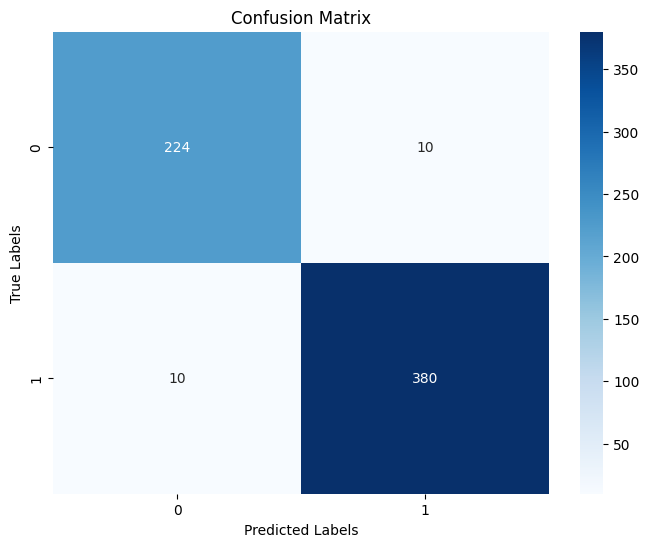

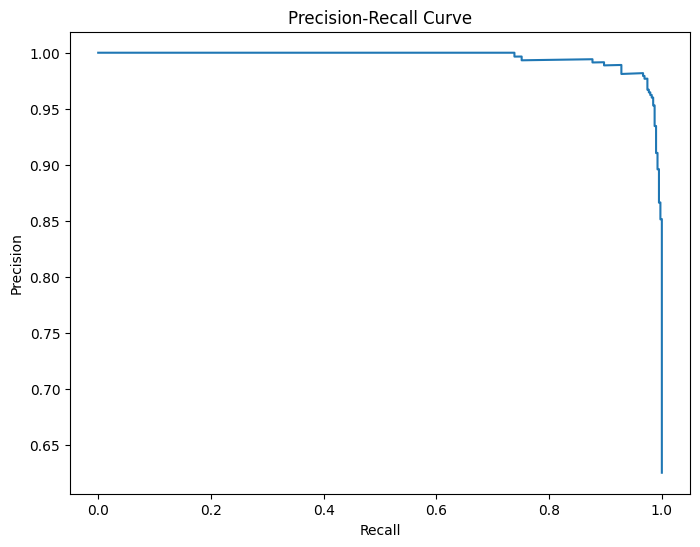

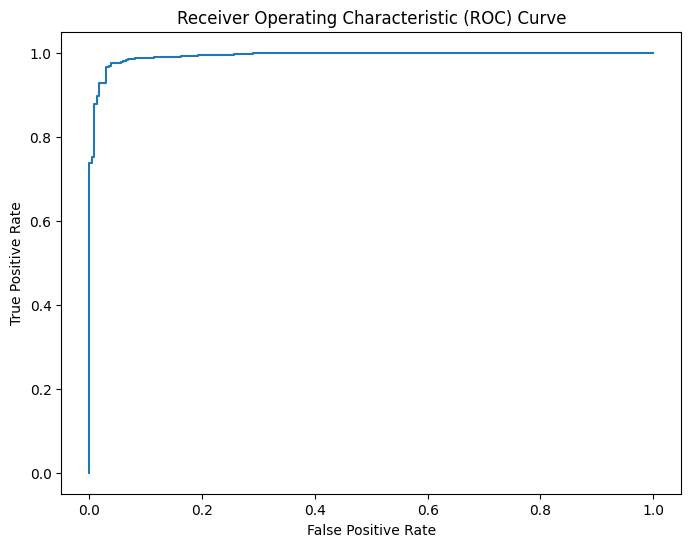

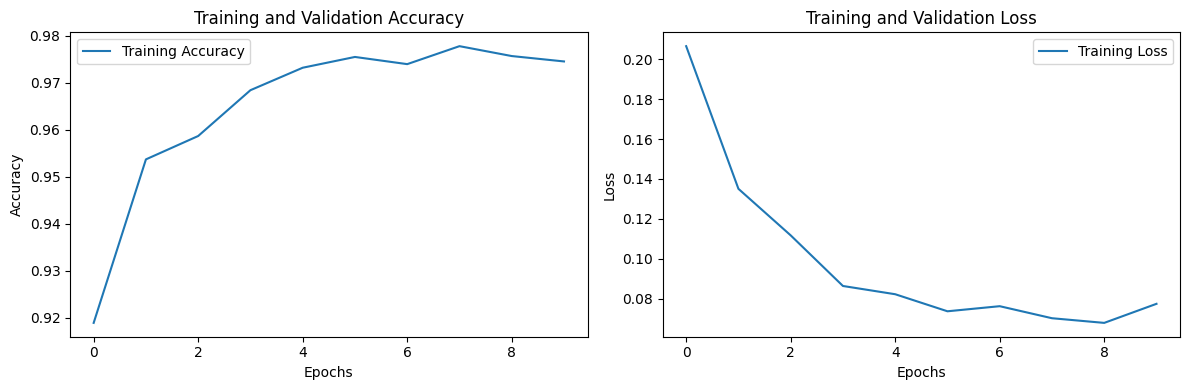

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot the precision-recall curve
precision, recall, _ = precision_recall_curve(true_labels, predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# Plot accuracy and loss curves over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


Based on the provided metrics for the Xception model, it achieved high accuracy (96.79%) and a balanced precision, recall, and F1 score of 0.9744. This indicates that the model performed well in correctly classifying the test samples and maintaining a good balance between true positive rate and false positive rate. Overall, the Xception model demonstrated strong performance and can be considered highly effective in the classification task.

# DenseNet Model

## Preprocess the data and create the datasets

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the train and test datasets
train_dir = '/content/labeled-chest-xray-images/chest_xray/train'
test_dir = '/content/labeled-chest-xray-images/chest_xray/test'

# Define the data augmentation settings
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

# Flow the augmented data from the directories
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_dataset = valid_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)




Found 5232 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Train the model

## The layer additions in this model, based on the DenseNet121 architecture, can be explained as follows:

The GlobalAveragePooling2D layer reduces the feature maps, the Dense layers introduce non-linearity and learn complex patterns, and the final Dense layer with softmax activation performs the classification, providing the probability distribution over the two classes.


In [25]:
# Load the pre-trained DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 10

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=num_epochs,
    verbose=1
)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
164/164 [==============================] - 140s 792ms/step - loss: 0.2441 - accuracy: 0.9019
Epoch 2/10
164/164 [==============================] - 126s 769ms/step - loss: 0.1551 - accuracy: 0.9400
Epoch 3/10
164/164 [==============================] - 126s 767ms/step - loss: 0.1495 - accuracy: 0.9394
Epoch 4/10
164/164 [==============================] - 130s 794ms/step - loss: 0.1232 - accuracy: 0.9518
Epoch 5/10
164/164 [==============================] - 125s 764ms/step - loss: 0.1307 - accuracy: 0.9480
Epoch 6/10
164/164 [==============================] - 130s 794ms/step - loss: 0.1323 - accuracy: 0.9478
Epoch 7/10
164/164 [==============================] - 133s 811ms/step - loss: 0.1231 - accuracy: 0.9536
Epoch 8/10
164/164 [==============================] - 135s 821ms/step - loss: 0.1081 - accuracy: 0.9572
Epoch 9/10
164/164 [==============================] - 133s 808ms/step - loss: 0.1126 - accuracy: 0.9547

## Evaluate the model

In [26]:
# Evaluate the model on the test set
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_dataset.classes

d_accuracy = accuracy_score(true_labels, predicted_labels)
d_precision = precision_score(true_labels, predicted_labels)
d_recall = recall_score(true_labels, predicted_labels)
d_f1 = f1_score(true_labels, predicted_labels)

# Print evaluation metrics
print(f"Test Accuracy: {d_accuracy * 100:.2f}%")
print(f"Precision: {d_precision:.4f}")
print(f"Recall: {d_recall:.4f}")
print(f"F1 Score: {d_f1:.4f}")


20/20 [==============================] - 10s 365ms/step
Test Accuracy: 91.51%
Precision: 0.9642
Recall: 0.8974
F1 Score: 0.9296


## Plot the results

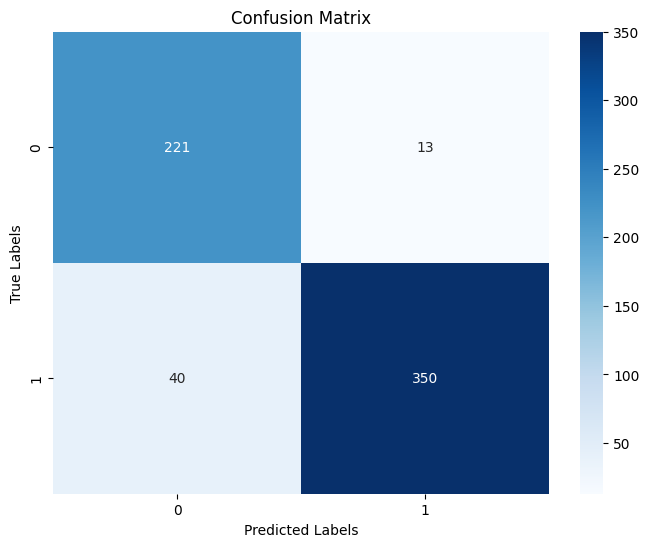

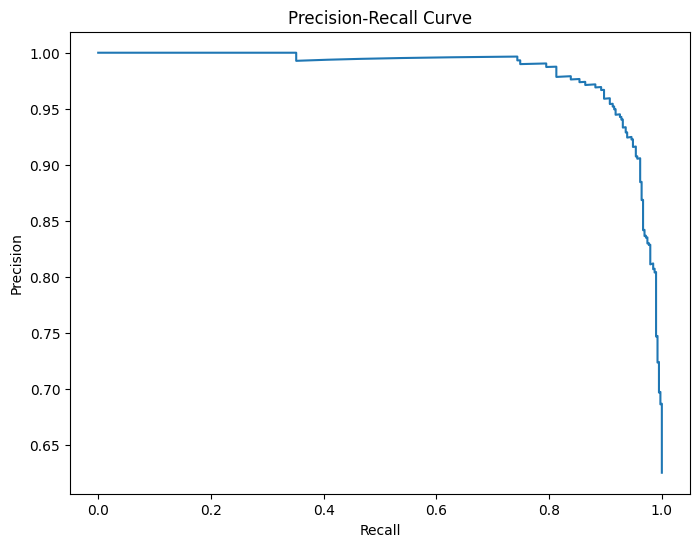

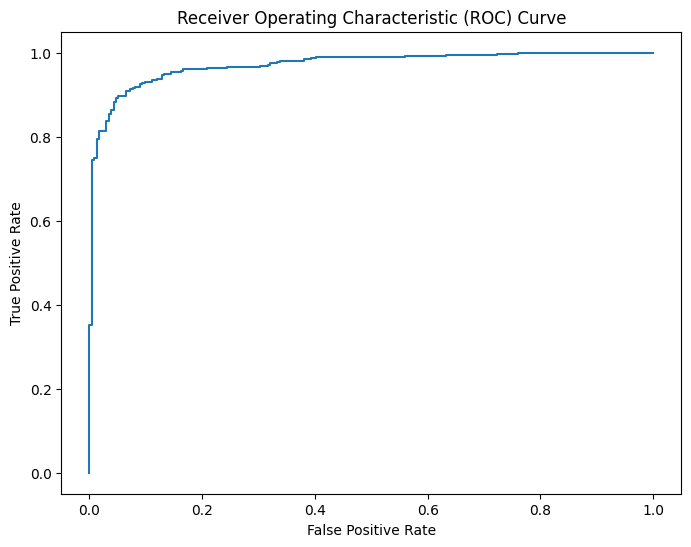

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot the precision-recall curve
precision, recall, _ = precision_recall_curve(true_labels, predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()



The model achieved a high accuracy, precision, recall, and F1 score, indicating its effectiveness in predicting the target classes. With a precision of 0.9642, the model has a high ability to correctly identify positive instances, while the recall of 0.8974 indicates a good ability to capture most of the positive instances. The F1 score of 0.9296 indicates a balanced performance between precision and recall. Overall, these metrics suggest that the model performs well and is capable of accurately predicting the target classes.






## Comparison

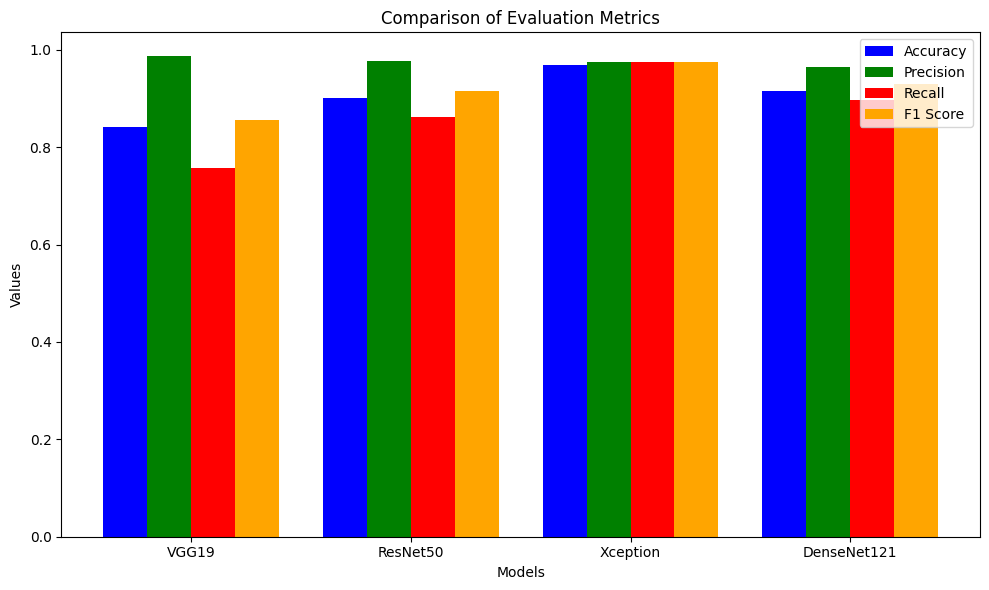

In [28]:
import matplotlib.pyplot as plt

# Define the model names and their corresponding evaluation metrics
models = ['VGG19', 'ResNet50', 'Xception', 'DenseNet121']
accuracy = [v_accuracy, res_accuracy, x_accuracy, d_accuracy]
precision = [v_precision, res_precision, x_precision, d_precision]
recall = [v_recall, res_recall, x_recall, d_recall]
f1 = [v_f1, res_f1, x_f1, d_f1]

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plot the grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, accuracy, color='b', width=bar_width, label='Accuracy')
plt.bar(r2, precision, color='g', width=bar_width, label='Precision')
plt.bar(r3, recall, color='r', width=bar_width, label='Recall')
plt.bar(r4, f1, color='orange', width=bar_width, label='F1 Score')

# Customize the plot
plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Comparison of Evaluation Metrics')
plt.xticks([r + bar_width*1.5 for r in range(len(models))], models)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


The Xception model achieved the highest accuracy (96.79%) and balanced precision, recall, and F1 score (0.9744). It is the top-performing model among the four.
The DenseNet121 model also performed well with a respectable accuracy (91.51%) and balanced precision, recall, and F1 score (0.9642). It is a strong contender but falls slightly behind Xception.
The ResNet121 and VGG19 models showed lower accuracy and varied precision, recall, and F1 score, indicating comparatively lower performance.
In conclusion, the Xception model demonstrates the best overall performance, while DenseNet121 is a close second.